In [1]:
import xarray as xr
import grib2io
import pandas as pd
import datetime
from glob import glob
from tqdm.auto import tqdm
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib
import scipy
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Data Assimilation

In the most general terms, data assimilation techniques attempt to combine theoretical models with observations (or really any two datasets) in the "best way possible" to improve both sets of data. This amounts to rectifying errors in both the forecast (magnitude, location and timing of event) and the necessarily sparse observations of the true system state: "for large scale systems, it is almost impossible to experimentally measure the full state of the system at a given time. For example, imagine simulating the atmospheric or oceanic flow, then you need to measure the velocity, temperature, density, etc. at every location corresponding to your numerical grid," (Ahmed+2020).

Data assimilation proceeds sequentially in time, applying a correction to the forecast based on a set of observed data and estimated errors that are present in both the observations and the forecast itself. The model organizes and propagates forward the information from previous observations. As new observations are added, that data is used to modify the model state to be as consistent as possible with them (i.e., data) *and* the previous information --> a sort of ouroboros of analysis and forecast.

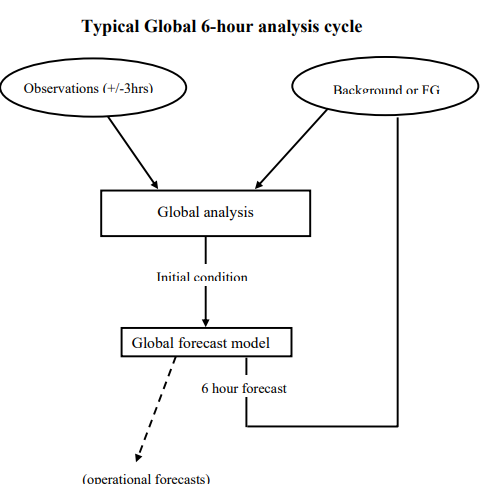


The very first step of the data assimilation cycle (which we don't see as it happens pre-blend) is the production of something like URMA -- taking irregularly spaced observations (both direct and indirect) of atmospheric state variables and estimating them onto a regular grid. Once gridded, these can be modified by the background field. And then applied to numerical models as a supplement for the ICs. 

As mentioned above, data assimilation amounts to a pre-process for NWPs but can also be used to combine predictions from several models + corrections from contemporaneous observations == the blend! BUT - correcting for the errors in the forecasts associated with both position and amplitude is difficult; "the standard measures of forecast skill, such as root-meansquare (r.m.s.) error and anomaly correlation all measure forecast error as the difference between a forecast and ananalysis at the same point in space and time. They are incapable of identifying a phase error as such. For example, a forecast of an intense, fast-moving feature can have a low skill score because of a small phase error that a human forecaster may consider minor. Hence, there is a need for an objective skill evaluation method that accounts for the presence of both phase and amplitude errors" (Nehrkorn+2003). 

Related is the treatment of probabilistic forecasts generated from ensembles of perturbed models. In the blend, there are ~17 models used to construct the value distributions for each variable (temp, precip, etc.). Some of these models are themselves made of an ensemble of models with different perturbation states (so in reality, 200+ realizations). In QM, each of these ensemble members would be mapped to the CDF constructed from the entire sample, but this can introduce issues originating from errors in the magnitude, timing, and location of weather events as predicted by the model. Furthermore, while QM (theoretically) provides really great probabilitic predictions for weather events, it's difficult to know how to communicate more deterministic estimates from an ensemble. 

An improvement we hope to make to the blend is to somehow efficiently combine the physically meaningful information encoded in the entire distribution of predictions from the ensemble. One way to do that is via coalescence, which seeks to quantify the uncertainity for coherent structures that can suffer multiple types of error in an ensemble of forecasts (as in above, it is necessary to correct for both phase and amplitude errors). "Consider, as an illustration, an ensemble of “one dimensional” fronts that contain position and amplitude errors, as shown in (the Figure below). If we were to ask what the mean front is, clearly the simplest solution is to take the mean of these fields, that is, calculate the mean vector. That would be terribly wrong, of course, because the mean simply does not look like any front in the ensemble. Coalescence instead calculates the mean amplitude field by marginalizing relative position errors. The method invokes an “N-body” type solution where each member in the ensemble gravitates to the others. In so doing, all of them discover a mean position where the amplitude mean is meaningful," (Ravela+2012)

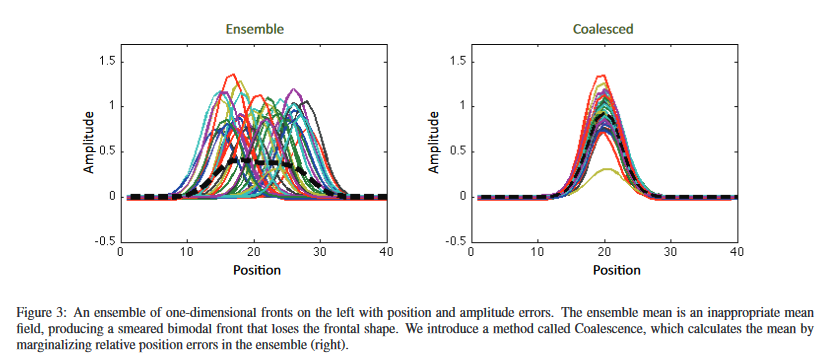

# Correcting Position and Amplitude Errors for NBM with Coalescence (Henderson, Hamill, and Nehrkorn, in prep.)

The corrrection and transformation of the distribution of forecasted features to deterministic products is nontrivial: "the raw ensemble mean is generally better than any single ensemble member in terms of mean squared errors, but predicted precipitation features are often unrealistic; because of differences in the position of precipitation features in the individual ensemble members, the ensemble mean areal extent is generally too large and the forecast extrema are too small. In addition, the ensemble mean product lacks fine-scale detail."

In the NBM, amplitude/additive corrections are made with the quantile mapping technique (see [the notebook on QMD in the Blend](https://github.com/SidneyLower-NOAA/mdl_smd_grib2io/blob/main/statistical_surveyor_of_sorts.ipynb)) but as of yet there is not a robust way to correct for position errors; the technique described in Henderson, Hamill, and Nehrkorn -- based on work by Nehrkorn, Auligne, and Hoffman 2014, Hoffman & Grassotti 1996, and Hoffman+1999 -- attempts to combine QM with coalescence in order to combine the information from the entire ensemble distribution (mindful of distribution variances which carry meaning).

## Feature Alignment Technique

Hoffman & Grassotti 1996 and Hoffman+1999, mentioned above, introduce a method for aligning forecast and observational data later called *Feature Calibration and Alignment* (FCA) by optimizing a set of vectors describing the spatial displacement and amplitude residuals between the two datasets. The alignment step is sometimes called *Feature Alignment Technique* (FAT) and can be used to align forecasts with observations or, like in coalescence, align ensemble members to arrive at a more physically meaningful ensemble mean. Below, I describe the feature alignment technique as outlined in Nehrkorn, Hamill, and Henderson (in prep) that aims to correct position errors between ensemble members before using QMD to correct amplitude errors between the ensemble and the analysis.

Determining a two-dimensional field of displacement vectors ($\delta$ **i**, $\delta$ **j**) that results in an improved agreement of a forecast **x** with available observations **y** is formulated as a nonlinear optimization of an objective function:

$$ J = J_r(\textbf{y}, H(\textbf{x}), \delta \textbf{i}, \delta \textbf{j}) + J_p (\delta \textbf{i}, \delta \textbf{j}) $$

where $J_r$ measures the residual errors of the adjusted field, $J_p$ is a penalty function that combines various constraints of the displacements, and $H$ is the observation operator that transform the forecast to observed variables. The displacements themselves are represented by a truncated double consine series, including only terms with a total wavenumber not exceeding some truncation wavenumber.

The residual error is calculated via 

$$ J_r = \sum_{n=1}^N {(y_n(i_n, j_n) - \textbf{x}(i_n + \delta \textbf{i}, j_n + \delta \textbf{j}))^2 \over \sigma_n^2} $$

over N observations. Importantly, FAT is versatile in that $y_n$ can be an analysis/observational dataset *or* something like the ensemble mean like in coalescence. The residual error just simply measures the mismatch between two datasets at the same location and time. 

The full penalty function is found by summing over the (weighted) individual penality functions that each constrain the displacements in a certain way:

$$ J_p = \lambda_a J_a + \lambda_d J_d + \lambda_m J_m + \lambda_{div} J_{div} $$

    "The barrier function $J_a$, which is evaluated in gridpoint space, is designed such that displacements larger than a typical displacement scale Si are penalized heavily. In the smoothness constraint $J_d$, evaluated in spectral space as described in Hoffman and Grassotti (1996), roughness is measured by the mean square Laplacian of the scaled displacements, which penalizes higher wavenumbers selectively. The magnitude constraint $J_m$, evaluated in spectral space, measures the mean square magnitude of the displacements, which penalizes all wavenumbers equally, and serves to suppress displacements in data-void areas. Finally, the divergence constraint $J_{div}$, evaluated in gridpoint space, limits the amount of divergence in the displacement field."

In the paper, the weights and free parameters that define each $J_p$ have been tuned from experiments comparing coalescned mean fields and selected ensemble member displacements.

## Demo: GEFS 6h precip

In [24]:
###     A Brief Aside to Download GEFS Data from AWS 
# /scratch2/STI/mdl-sti/Sidney.Lower/test_data/gefs/get_gefs_data.py
#g = grib2io.open('/scratch2/STI/mdl-sti/Sidney.Lower/test_data/gefs/20210601/gefs01.t12z.f006')

In [2]:
#get GEFS members

#initialized 3/16/2018 at 0z
#valid at 3/22/2018 12z

date = '20231005'
lead_time = 120 #hours
dat_dir = f'/scratch2/STI/mdl-sti/Sidney.Lower/test_data/gefs/{date}/'
gefs_paths = sorted(glob(dat_dir+f'gefs*.t0z.f120'))
filters = dict(productDefinitionTemplateNumber=11, shortName='APCP')
gefs_data = xr.open_mfdataset(gefs_paths, chunks=None,engine='grib2io', filters=filters, 
                              parallel=False, concat_dim=[pd.Index(np.arange(len(gefs_paths)), name="member")],combine="nested")


In [28]:
gefs_data

<xarray.Dataset>
Dimensions:                   (member: 30, y: 721, x: 1440)
Coordinates:
    refDate                   datetime64[ns] 2023-10-05
    leadTime                  timedelta64[ns] 5 days
    valueOfFirstFixedSurface  float64 0.0
    duration                  timedelta64[ns] 06:00:00
    perturbationNumber        (member) int64 1 2 3 4 5 6 7 ... 25 26 27 28 29 30
    latitude                  (y, x) float64 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    longitude                 (y, x) float64 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    validDate                 datetime64[ns] 2023-10-10
  * member                    (member) int64 0 1 2 3 4 5 6 ... 24 25 26 27 28 29
Dimensions without coordinates: y, x
Data variables:
    APCP                      (member, y, x) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    engine:   grib2io

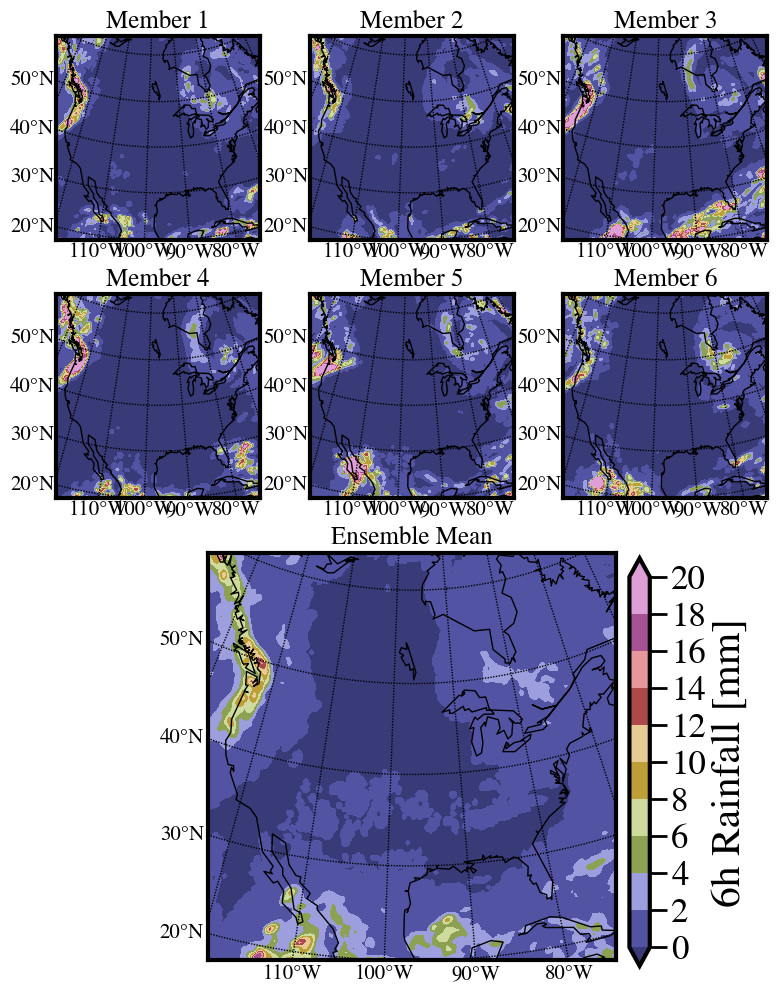

In [29]:
fig, axes = plt.subplot_mosaic("ABC;DEF;GGG", figsize=(12,12),height_ratios=[1,1,2])
temp_range = np.arange(0,22,2)
plt.subplots_adjust(hspace=0.2,wspace=-0.4)
lats, lons = gefs_data.latitude.data, gefs_data.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=42,width=5e6,height=5e6,resolution='c')
xx, yy = m(lons, lats) #note to self, x=lons y=lats

for mem, ax in enumerate(['A', 'B', 'C', 'D', 'E', 'F']):
        gefs_pcp = gefs_data.APCP.data[mem]
        cs = m.contourf(xx,yy,gefs_pcp,levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[ax])
        m.drawcoastlines(ax=axes[ax])
        m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=15,ax=axes[ax])
        m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=15,ax=axes[ax])
        axes[ax].set_title(f'Member {mem+1}', fontsize=18)

ens_mean = gefs_data.APCP.mean(dim='member')
raw_mean = ens_mean.data.compute()
ax='G'
cs = m.contourf(xx,yy,raw_mean,levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[ax])
m.drawcoastlines(ax=axes[ax])
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=15,ax=axes[ax])
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=15,ax=axes[ax])
axes[ax].set_title(f'Ensemble Mean', fontsize=18)

cbar_ax = inset_axes(axes['G'],
                    width="5%",  
                    height="100%", 
                    loc='upper left',bbox_to_anchor=(1, 0.02, 1, 1),bbox_transform=axes['G'].transAxes)

cbar=plt.colorbar(cs,orientation='vertical', cax=cbar_ax,ticks=np.arange(0,22,2))
cbar.set_label('6h Rainfall [mm]')

In [3]:
#objective function
def get_j(ck_arr, b_ik, mean, ens_mem, obs_error, S_grid,S_spec,grid, m_k, n_k, grid_def, min_lat, min_lon):
    ntrunc = np.shape(b_ik)[1]
    c_k = {"x": ck_arr[:ntrunc], "y": ck_arr[ntrunc:ntrunc*2], "a": ck_arr[ntrunc*2:]}
    j_r = residual_error(c_k, b_ik, mean,ens_mem,obs_error,grid, grid_def, min_lat, min_lon)
    j_a = barrier_func_gp(c_k, b_ik, S_grid)
    j_d = smoothness_func_spec(c_k, m_k, n_k, S_spec)
    #j_div = divergence_func_gp(c_k, b_ik)
    j_m = magnitude_func_spec(c_k, m_k, n_k,S_spec)

    lambda_spec = (np.shape(mean)[0]*np.shape(mean)[1]) / (len(m_k))
    #print('returning j')
    return np.log10(j_r + j_a + lambda_spec*j_d + lambda_spec*j_m)

def evaluate_at_new_grid(new_grid, grid_shape, grid_def, ens_mem,min_lat_idx, min_lon_idx, c_ai):
    
    #interpolate ensemble member between displaced grid and gefs grid
    displaced_ens = grib2io.interpolate_to_stations(ens_mem, 'bilinear', grid_def, new_grid[1], new_grid[0])
    
    # interp_to_stations returns a list of points instead of the 2D field. just need to rearrange below
    coalesced_ensemble = np.zeros(np.shape(ens_mem))
    y,x = grid_shape
    for i in range(x):
        for j in range(y):
            point = i + x*j
            coalesced_ensemble[j+min_lat_idx, i+min_lon_idx] = displaced_ens[point] * (1. + c_ai[point])
    return coalesced_ensemble

def residual_error(c_k,b_ik,ens_mean, ens_mem, obs_error, grid, grid_def, min_lat, min_lon):
    #grid point displacements from coeff * basis funcs
    gefs_grid_points = np.reshape((grid[0], grid[1]), (2, -1), order='C').T
    grid_shape = np.shape(grid[0])
    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    n_x_i = gefs_grid_points[:,0] + c_xi
    n_y_i = gefs_grid_points[:,1] + c_yi
   
    #amplitude displacements
    c_ai = np.dot(b_ik, c_k['a'])

    displaced_ens = evaluate_at_new_grid((n_x_i, n_y_i), grid_shape,grid_def, ens_mem, min_lat,min_lon, c_ai)

    max_lat = min_lat + grid_shape[0]
    max_lon = min_lon + grid_shape[1]
    before_sum = (ens_mean[min_lat:max_lat, min_lon:max_lon] - displaced_ens[min_lat:max_lat, min_lon:max_lon])**2
    return np.sum(before_sum / obs_error[min_lat:max_lat, min_lon:max_lon]**2)

def barrier_func_gp(c_k, b_ik,S_grid): #Ja
    #get displacements in grid space
    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    c_ai = np.dot(b_ik, c_k['a'])
    return np.sum((c_xi / S_grid)**20) +  np.sum((c_yi / S_grid)**20) + np.sum((c_ai / S_grid)**20)

def smoothness_func_spec(c_k, m_k, n_k, S_spec): #Jd
    nu_k = (m_k**2 + n_k**2)**(2)
    
    w_x = (1. / .1**2) * nu_k
    w_y = (1. / .1**2) * nu_k
    w_a = (1. / .1**2) * nu_k
    return np.sum(np.array([w_x, w_y,w_a]) *
                             np.array([c_k['x'], c_k['y'], c_k['a']]) ** 2)

def divergence(field):
    return np.sum(np.gradient(field),axis=0)
    

def magnitude_func_spec(c_k, m_k, n_k,S_spec):
    nu=1.
    d_o_f = len(m_k)
    n4nu_k = np.repeat(np.mean((m_k**2 + n_k**2)**(2*nu)), d_o_f)
    w_x = (1. / S_spec**2) * n4nu_k
    w_y = (1. / S_spec**2) * n4nu_k
    w_a = (1. / S_spec**2) * n4nu_k
    return np.sum(np.array([w_x, w_y, w_a]) *
                             np.array([c_k['x'], c_k['y'], c_k['a']]) ** 2)
    

Finding grid displacements in 2D with more complicated coherent structures and larger parameter space necessitates a more sophisticated handling of the displacements. In Henderson, Hamill, and Nehrkorn, (in prep), following Hoffman & Grassotti 1996, the displacements are represented by a truncated double consine series, and we are searching for the optimal coefficients for those basis functions:


$$ B_{k} = 2 \sin (m_k (ax + \frac{\pi}{2})) \sin(n_k (ay + \frac{\pi}{2}))$$

where $m_k$, $n_k$ are determined by the choice of truncation wavenumber and $k$ are the wavenumbers up to that truncation == degrees of freedom. This allows us to reduce the number of parameters to minimize from grid N lat x M longitude to ~10-20 thanks to the basis function truncation.

The objects to be minimized are then coefficients to these basis functions ($\Delta x, \Delta y$), with the distorted grid locations in physical/grid space found via

$$ x' = x + B\Delta x$$
$$ y' = y + B\Delta y$$



Below includes functions to calculate the set of basis functions by transforming the physical grid locations into Fourier space.

In [4]:
def basis_functions(gefs_grid_points, m_k=None, n_k=None, xrange=(np.nan, np.nan), yrange=(np.nan, np.nan)):

    #transform grid points to Fourier space
    x = grid2fourier(gefs_grid_points[:,0], xrange)
    y = grid2fourier(gefs_grid_points[:,1], yrange)

    #calculate basis functions 
    b_ik = np.zeros((len(gefs_grid_points), len(m_k)))
    for mk in range(len(m_k)):
            b_ik[:, mk] = 2 * np.sin(m_k[mk] * gefs_grid_points[:,0]) * np.sin(n_k[mk] * gefs_grid_points[:,1])

    return b_ik

def grid2fourier(x, xrange):
    return (np.pi / np.diff(xrange)) * (x - xrange[0])

def basis_truncation(n=3):
    #select wavenumbers below truncation limit
    m_k = np.tile(np.arange(1, n+1),n)
    n_k = np.repeat(np.arange(1, n + 1), n)
    select = m_k**2 + n_k**2 <= n**2

    return m_k[select], n_k[select]

In [8]:
#setup displacements
min_lon = 360 #roughly 180-55 deg W
max_lon = 615
min_lat = 60 #roughly 10-60 deg N
max_lat = 161

m_k, n_k = basis_truncation(7) #truncating the basis functions B_k to wavenumbers < 7
y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
gy, gx=np.meshgrid(y,x ,indexing='ij')
gefs_grid_points = np.reshape((gx, gy), (2, -1), order='C').T
#get displacement basis functions, transforms grid x,y to fourier space
b_ik = basis_functions(gefs_grid_points, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]]
    )
d_o_f = len(m_k)
#basis function coefficients, the target of our minimization
c_k = {"x": np.repeat(0.5, d_o_f), "y": np.repeat(-0.5, d_o_f), 'a': np.random.uniform(0.5, 2.,size=d_o_f)}

#physical displacements
c_xi = np.dot(b_ik, c_k['x'])
c_yi = np.dot(b_ik, c_k['y'])
n_x_i = gefs_grid_points[:,0] + c_xi
n_y_i = gefs_grid_points[:,1] + c_yi


Here, I set the basis function coefficients to 0.5, which when dotted with the basis functions, give us the physical displacements in grid space. The purpose of the minimization process is to determine these coefficients to get the best alignment between the target (e.g., the ensemble mean) and each ensemble member.

/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


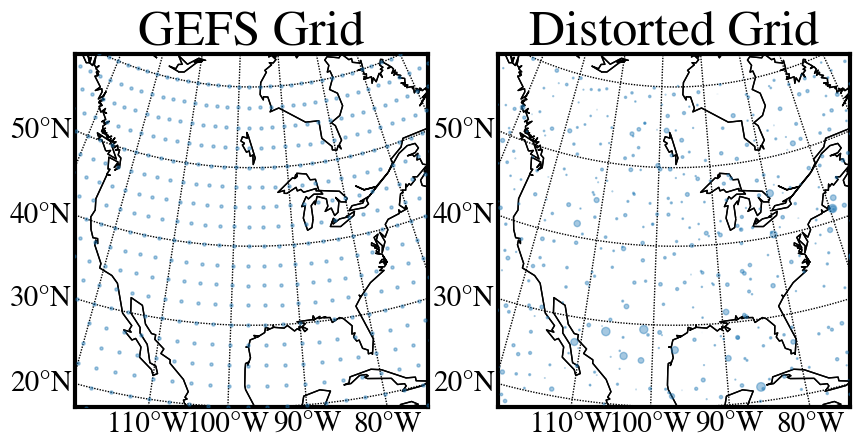

In [15]:
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))

axes[0].set_title('GEFS Grid')
y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
m = Basemap(projection='lcc',lon_0=-97,lat_0=42,width=5e6,height=5e6,resolution='c')
xx, yy = m(*np.meshgrid(x[::5],y[::5]))
axes[0].scatter(xx,yy, zorder=10, alpha=0.4, s=5) 
m.drawcoastlines(ax=axes[0])


dxx, dyy = m(n_x_i[::12], n_y_i[::12])
c_ai = np.dot(b_ik, c_k['a'])
axes[1].scatter(dxx,dyy, zorder=10, alpha=0.4, s=c_ai[::12]) 
m.drawcoastlines(ax=axes[1])
axes[1].set_title('Distorted Grid')

for ax in range(2):
    m.drawcoastlines(ax=axes[ax])
    m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=21,ax=axes[ax])
    m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=21,ax=axes[ax])

The dataset we are using (GEFS 20 ensemble members at 1 degree resolution from March 16, 2018 0z valid March 22, 2018 12z) is situated on a global grid. We'll select a subsection of the grid to cover ~CONUS area (matching the lat/lon span in Henderson, Hamill, and Nehrkorn == 180-55 degrees W, 10-60 degrees N).

In [5]:
def find_nearest_lat_lon(lat_lon_range, lat_lon_arr):
    min_val, max_val = lat_lon_range[0], lat_lon_range[1]
    min_idx = (np.abs(np.array(lat_lon_arr)-min_val)).argmin()
    max_idx = (np.abs(np.array(lat_lon_arr)-max_val)).argmin()
    if min_idx > max_idx: #latitude
        trimmed_arr = lat_lon_arr[max_idx:min_idx+1]
        return trimmed_arr, max_idx, min_idx
    else:
        trimmed_arr = lat_lon_arr[min_idx:max_idx+1]
        return trimmed_arr, min_idx, max_idx

In [6]:
#--------------------------------------#
#
#  Get GEFS data: ensemble mean, ensemble members
#
#--------------------------------------#

ens_mean = gefs_data.APCP.mean(dim='member')
raw_mean = ens_mean.data.compute()
ens_members = gefs_data.APCP.data.compute()
ens_std = gefs_data.APCP.std(dim='member').data.compute()

lats = gefs_data.latitude.data.compute().T[0]
lons = gefs_data.longitude.data[0].compute()
y, min_lat, max_lat = find_nearest_lat_lon([10,60], lats)

lon_range = 180 - np.array([180, 55]) + 180 #convert from 0-360 to East / West
x, min_lon, max_lon = find_nearest_lat_lon(lon_range, lons)

In Henderson, Hamill, and Nehrkorn (in prep.), the R source code used to optimize these displacements uses the nlminb function, an unconstrained and bounds-constrained quasi-Newton method optimizer based on a FORTRAN routine. In python, an equivalent method is scipy's SLSQP, also a quasi-Newtonian bound-constrained minimization routine, so we use that below. Now that we've defined the objective function and its components, we can setup our minimization problem. 

However, there are a few free parameters that the objective function depends on, namely the ensemble standard deviation and the scale factors used in the barrier, smoothness, and magnitude penalty functions. From Henderson, Hamill, and Nehrkorn:

    "Sensitivity experiments with varying values for these parameters were evaluated through inspection of coalesced mean fields and selected ensemble member displacements in order to develop an initial “tuned” set of parameters: 𝑆 = 700𝑘𝑚, 𝑁𝑡𝑟𝑢𝑛𝑐 = 7, 𝜎 = 5𝑚𝑚 for precipitable water, 𝜎 = 1.3𝑚𝑚 for total precipitation, and 𝜆𝑝 = 1 for all terms 𝑝. 

    For the final configuration applied to the GEFSv12 forecasts, we modified these initial parameters as follows: the weights for the smoothness and magnitude constraints were rescaled to take into account the difference in the way these penalty functions are computed: The smoothness constraint is computed in spectral space (with 60 degrees of freedom, i.e. contributing terms to the penalty function), while the divergence constraint is summed over each grid point (100,794 in our case). Accordingly, 𝜆𝑝 was set to the ratio of the number of terms (1680) for the smoothness and magnitude constraints. 

    In addition, we modified the length scale parameter – which represents the maximum expected displacements used in the FAT algorithm based on forecast length. We derived a scaling factor based on reported error growth of GFS hurricane track errors. The average of values reported in Dong et al. (2020) and Hazelton et al. (2018) is shown in Table 2, along with our derived scaling factor applied to the 96-hr value. Linear interpolation/extrapolation was used to arrive at the value of 𝑆 for each forecast length."

Based on this, we adopt the value of 1.3mm for the ensemble standard deviation for the 6h precip and #grid points / degrees of freedom for the penalty functions calculated in spectral space. The scale (S) is time dependent; as we are interested in only the 6 hour forecast range, we adopt the value S = 70 km based on their Table 2, which roughly corresponds to S = 1 degree. 

In [7]:
#setup basis functions
m_k, n_k = basis_truncation(7) #truncating the basis functions B_k to wavenumbers < 7
gy, gx=np.meshgrid(y,x ,indexing='ij')
gefs_grid_points = np.reshape((gx, gy), (2, -1), order='C').T
b_ik = basis_functions(gefs_grid_points, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]])
d_o_f = len(m_k)
#native GEFS grid
grid_def = gefs_data.grib2io.griddef()
grid = (gx, gy)

#free parameters
std = ens_std
std[std == 0] = 0.001
S_a = 1.32 * (7.)
S_mag = 10.

def minimize_routine(mem):
    print(f'\nminimizing member {mem}')
    ens_mem = ens_members[mem]
    #initialize coefficients
    c_k = {"x": np.repeat(0.01, d_o_f), "y": np.repeat(0.01, d_o_f), "a": np.repeat(0.01, d_o_f)}
    ck_arr = np.ravel(np.array([c_k['x'], c_k['y'], c_k['a']])) 
    #minimize
    minimize = scipy.optimize.minimize(fun=get_j,x0=ck_arr ,jac=None, 
                                       args=(b_ik, raw_mean, ens_mem, std, S_a, S_mag,grid, m_k, n_k, grid_def, min_lat, min_lon),
                                       method='SLSQP',options={'disp':True, 'maxiter': 250})
    print('    done minimizing')
    #coalesced grid
    ntrunc = np.shape(b_ik)[1]
    c_k_minimized = {"x": ck_arr[:ntrunc], "y": ck_arr[ntrunc:ntrunc*2], "a": ck_arr[ntrunc*2:]}
    c_xi = np.dot(b_ik, c_k_minimized['x'])
    c_yi = np.dot(b_ik, c_k_minimized['y'])
    n_x_i = gefs_grid_points[:,0] + c_xi
    n_y_i = gefs_grid_points[:,1] + c_yi
    c_ai = np.dot(b_ik, c_k_minimized["a"])
    
    aligned_ens = evaluate_at_new_grid((n_x_i, n_y_i),np.shape(gx), grid_def, ens_mem, min_lat,min_lon, c_ai)

    print(f'*** DONE member {mem} ***')
    return aligned_ens

In [ ]:
start = datetime.datetime.now()
test = minimize_routine(10)
finish = datetime.datetime.now()
print(f'finished in {(finish-start).total_seconds()}s')


minimizing member 10


In [12]:
start = datetime.datetime.now()
with multiprocessing.Pool(16) as p:
    result = p.map(minimize_routine, np.arange(np.shape(ens_members)[0]))
    #result = p.map(minimize_routine, np.arange(3))
finish = datetime.datetime.now()
print(f'finished entire ensemble in {(finish-start).total_seconds()}s')


minimizing member 2
minimizing member 0
minimizing member 1
minimizing member 3
minimizing member 4
minimizing member 5
minimizing member 6
minimizing member 7
minimizing member 8
minimizing member 9




minimizing member 10


minimizing member 11

minimizing member 12
minimizing member 13
minimizing member 14
minimizing member 15










KeyboardInterrupt: 

In [6]:
from grib2io_interp import get_openmp_threads, set_openmp_threads

In [7]:
set_openmp_threads(4)

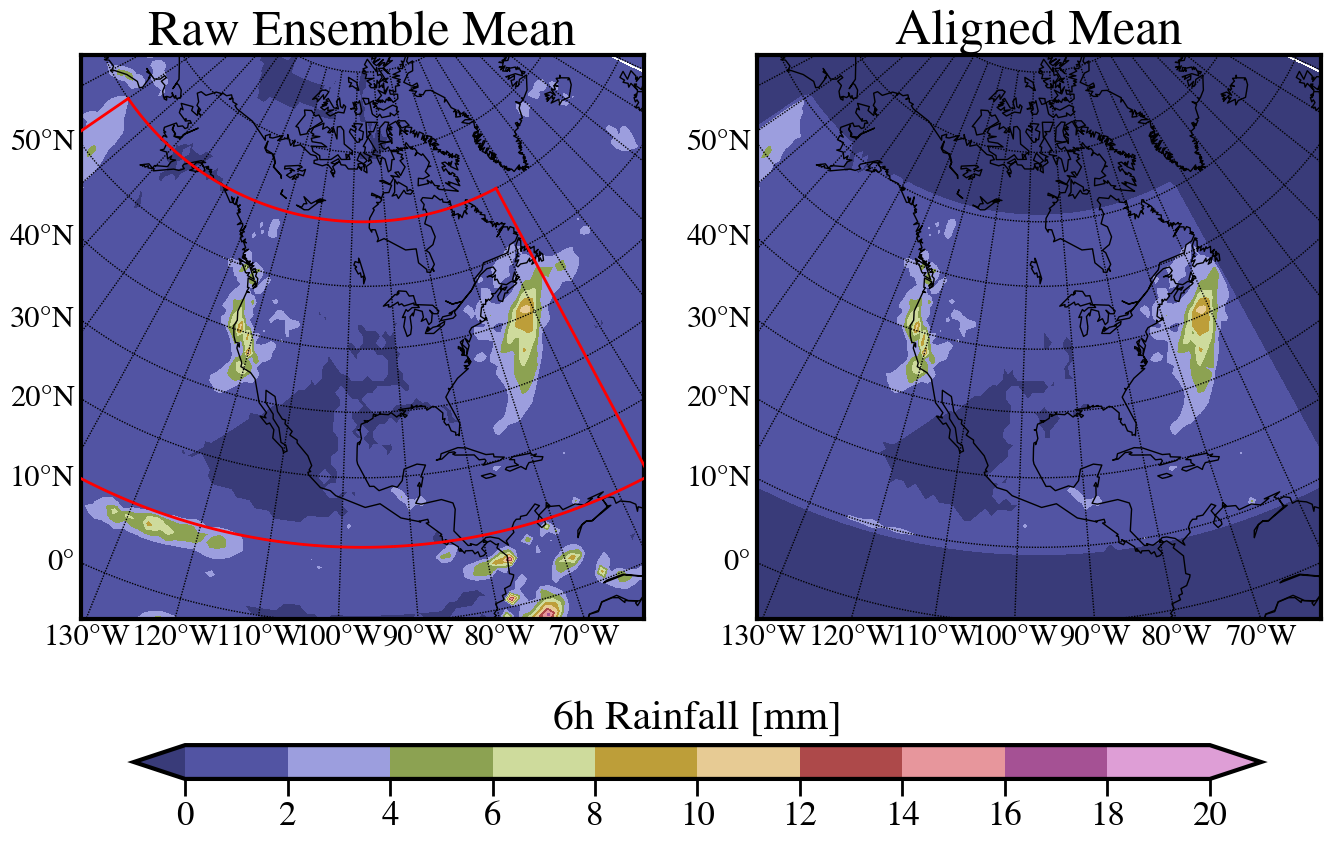

In [9]:
fig, axes = plt.subplots(1,2, figsize=(16,12), sharey=True)
temp_range = np.arange(0,22,2)

#GEFS
lats, lons = gefs_data.latitude.data, gefs_data.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=42,width=1e7,height=1e7,resolution='c')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
cs = m.contourf(xx,yy,raw_mean,levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[0])
axes[0].set_title('Raw Ensemble Mean')
cbar_ax = inset_axes(axes[0],
                    width="200%",  # width = 50% of parent_bbox width
                    height="6%",  # height : 5%
                    loc='upper left',bbox_to_anchor=(0.07, -1.2, 1, 1),bbox_transform=axes[0].transAxes)

cbar=plt.colorbar(cs,orientation='horizontal', cax=cbar_ax,ticks=np.arange(0,22,2))
cbar.ax.set_xticklabels(['0','2','4', '6', '8', '10','12','14','16','18','20']) 
cbar.set_label('6h Rainfall [mm]', labelpad=-95)

box = m(x, np.repeat(np.max(y), len(x)))
m.plot(*box, linewidth=2, color='red', ax=axes[0], zorder=10)
box = m(x, np.repeat(np.min(y), len(x)))
m.plot(*box, linewidth=2, color='red', ax=axes[0], zorder=10)
box = m(np.repeat(np.max(x), len(y)), y)
m.plot(*box, linewidth=2, color='red', ax=axes[0], zorder=10)
box = m(np.repeat(np.min(x), len(y)), y)
m.plot(*box, linewidth=2, color='red', ax=axes[0], zorder=10)


axes[1].set_title(f'Aligned Mean')
cs = m.contourf(xx,yy,np.mean(result,axis=0),levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[1],)

for ax in range(2):
    m.drawcoastlines(ax=axes[ax])
    m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes[ax])
    m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes[ax])


Henderson, Hamill, and Nehrkorn's routine performs a second minimization to align the ensemble members to the coalesced mean generated from the optimal alignment field in the first iteration. We'll do that below:

In [10]:
#----------------------------------#
#
#   Second Alignment
#----------------------------------#

alignment_field = np.mean(result,axis=0) #mean of coalesced members


def second_alignment(mem):
    print(f'\nminimizing member {mem}')
    ens_mem = ens_members[mem]
    #initialize coefficients
    c_k = {"x": np.repeat(0.01, d_o_f), "y": np.repeat(0.01, d_o_f), "a": np.repeat(0.01, d_o_f)}
    ck_arr = np.ravel(np.array([c_k['x'], c_k['y'], c_k['a']])) 
    #minimize
    minimize = scipy.optimize.minimize(fun=get_j,x0=ck_arr ,jac=None, 
                                       args=(b_ik, alignment_field, ens_mem, std, S_a, S_mag,grid, m_k, n_k, grid_def, min_lat, min_lon),
                                       method='SLSQP',options={'disp':True, 'maxiter': 250})
    print('    done minimizing')
    #coalesced grid
    ntrunc = np.shape(b_ik)[1]
    c_k_minimized = {"x": ck_arr[:ntrunc], "y": ck_arr[ntrunc:ntrunc*2], "a": ck_arr[ntrunc*2:]}
    c_xi = np.dot(b_ik, c_k_minimized['x'])
    c_yi = np.dot(b_ik, c_k_minimized['y'])
    n_x_i = gefs_grid_points[:,0] + c_xi
    n_y_i = gefs_grid_points[:,1] + c_yi
    c_ai = np.dot(b_ik, c_k_minimized["a"])
    
    aligned_ens = evaluate_at_new_grid((n_x_i, n_y_i),np.shape(gx), grid_def, ens_mem, min_lat,min_lon, c_ai)

    print(f'*** DONE member {mem} ***')
    return aligned_ens

In [11]:
start = datetime.datetime.now()
with multiprocessing.Pool(16) as p:
    result2 = p.map(second_alignment, np.arange(np.shape(ens_members)[0]))
finish = datetime.datetime.now()
print(f'finished entire ensemble in {(finish-start).total_seconds()}s')


minimizing member 2
minimizing member 0
minimizing member 1
minimizing member 3
minimizing member 4
minimizing member 5
minimizing member 7


minimizing member 8
minimizing member 9



minimizing member 10


minimizing member 11
minimizing member 13
minimizing member 12


minimizing member 14
minimizing member 15






minimizing member 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.950111625707531
            Iterations: 28
            Function evaluations: 2701
            Gradient evaluations: 28
    done minimizing
*** DONE member 9 ***

minimizing member 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.362506632394453
            Iterations: 38
            Function evaluations: 3583
            Gradient evaluations: 38
    done minimizing
*** DONE member 10 ***

minimizing member 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.031481440088532

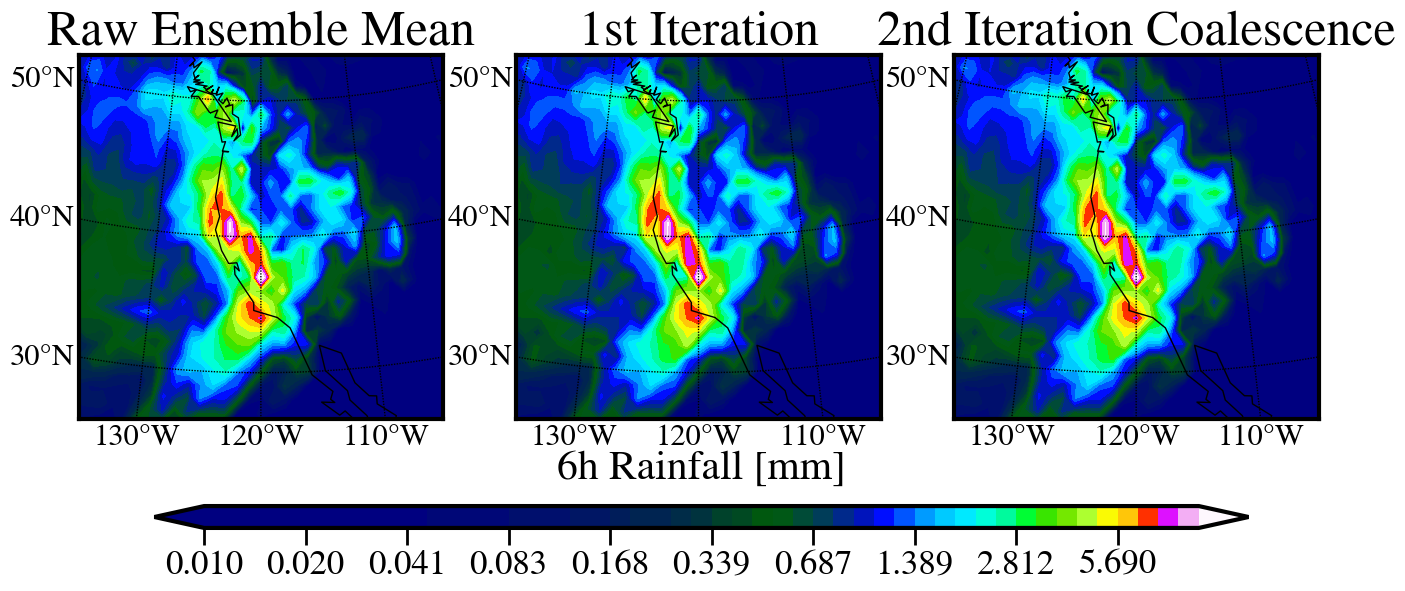

In [22]:
fig, axes = plt.subplots(1,3, figsize=(16,12), sharey=True)
temp_range = np.logspace(np.log10(0.01),np.log10(10.), 50)

#GEFS
lats, lons = gefs_data.latitude.data, gefs_data.longitude.data
m = Basemap(projection='lcc',lon_0=-120,lat_0=40,width=3e6,height=3e6,resolution='c')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
cs = m.contourf(xx,yy,raw_mean,levels=temp_range,cmap=plt.cm.gist_ncar,extend='both',ax=axes[0])
axes[0].set_title('Raw Ensemble Mean')
cbar_ax = inset_axes(axes[0],
                    width="300%",  # width = 50% of parent_bbox width
                    height="6%",  # height : 5%
                    loc='upper left',bbox_to_anchor=(0.17, -1.2, 1, 1),bbox_transform=axes[0].transAxes)

cbar=plt.colorbar(cs,orientation='horizontal', cax=cbar_ax)
#cbar.ax.set_xticklabels(['0','2','4', '6', '8', '10','12','14','16','18','20']) 
cbar.set_label('6h Rainfall [mm]', labelpad=-95)

axes[1].set_title(f'1st Iteration')
cs = m.contourf(xx,yy,np.mean(result,axis=0),levels=temp_range,cmap=plt.cm.gist_ncar,extend='both',ax=axes[1],)


axes[2].set_title(f'2nd Iteration Coalescence')
cs = m.contourf(xx,yy,np.mean(result2,axis=0),levels=temp_range,cmap=plt.cm.gist_ncar,extend='both',ax=axes[2],)

for ax in range(3):
    m.drawcoastlines(ax=axes[ax])
    m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes[ax])
    m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes[ax])


## Validation

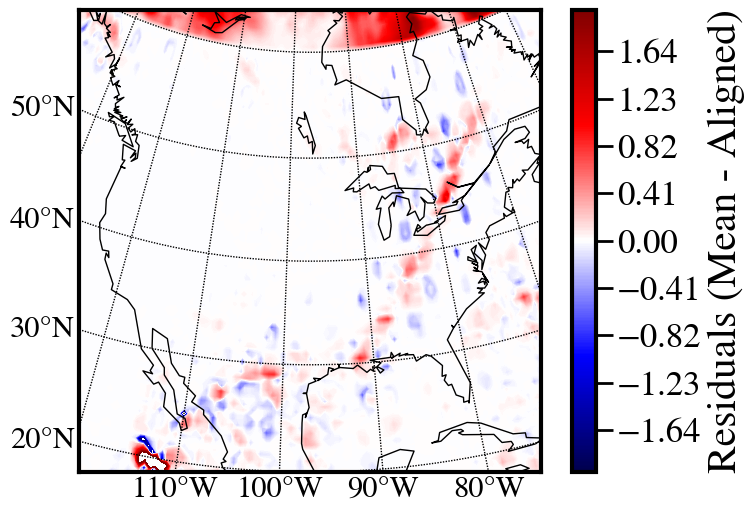

In [21]:
resid_range = np.arange(-2, 2.01, 0.01)
lats, lons = gefs_data.latitude.data, gefs_data.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=42,width=5e6,height=5e6,resolution='c')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
cs = m.contourf(xx,yy,raw_mean - np.mean(result2, axis=0) ,levels=resid_range,cmap=plt.cm.seismic)

m.drawcoastlines()
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22)
plt.colorbar(cs, label='Residuals (Mean - Aligned)')

In [22]:
def find_nearest(array,value):
    idx = (np.abs(np.array(array)-value)).argmin()
    return idx

/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/tmp/ipykernel_3589987/718702565.py:31: RuntimeWarning: divide by zero encountered in log10
  cs = m.contourf(xx,yy,np.log10(np.std(result2,axis=0)),levels=temp_range,cmap=plt.cm.jet,ax=axes[1],)


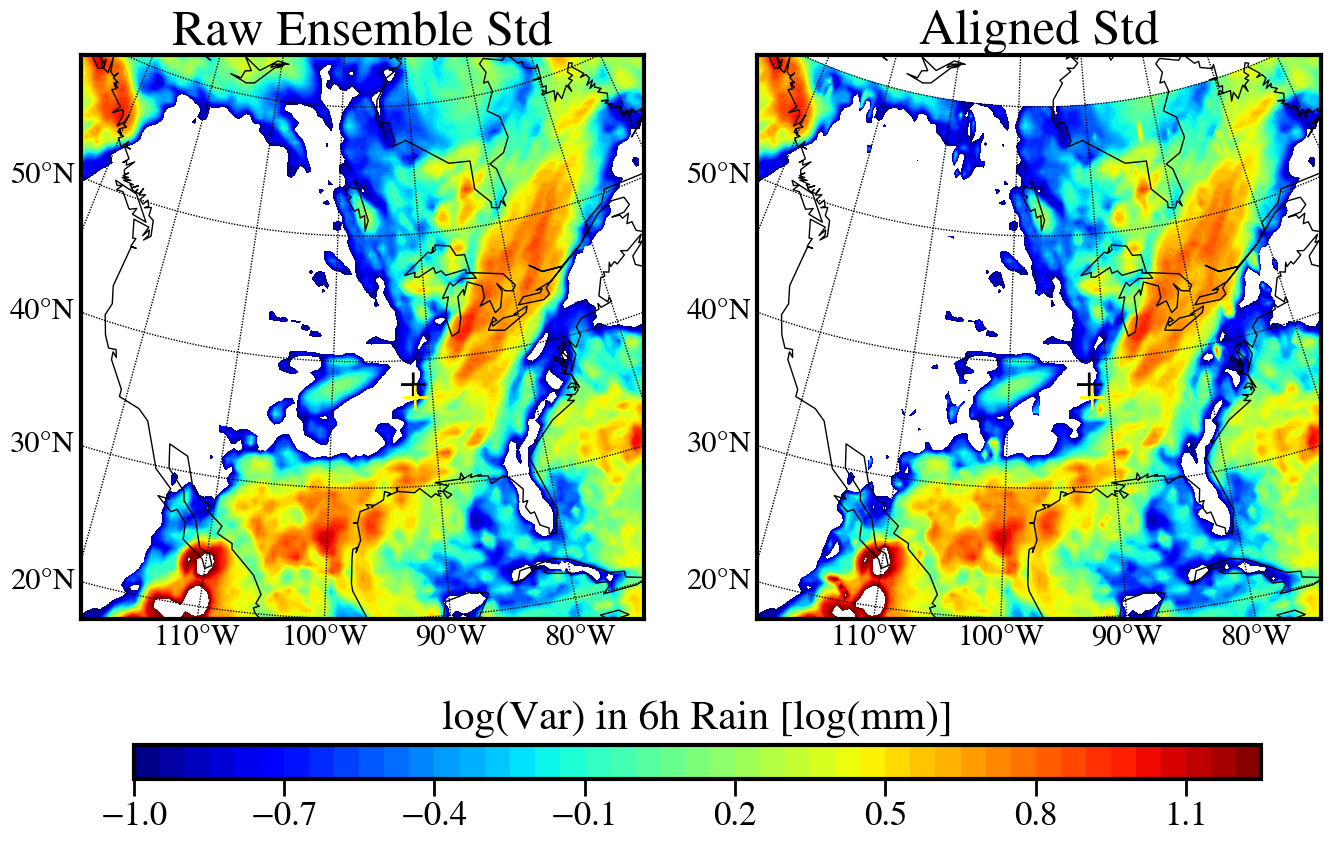

In [23]:
fig, axes = plt.subplots(1,2, figsize=(16,12), sharey=True)
temp_range = np.arange(-1,1.3,0.05)

#GEFS
lats, lons = gefs_data.latitude.data, gefs_data.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=42,width=5e6,height=5e6,resolution='c')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
cs = m.contourf(xx,yy,np.log10(gefs_data.APCP.std(dim='member')),levels=temp_range,cmap=plt.cm.jet,ax=axes[0])
axes[0].set_title('Raw Ensemble Std')
cbar_ax = inset_axes(axes[0],
                    width="200%",  # width = 50% of parent_bbox width
                    height="6%",  # height : 5%
                    loc='upper left',bbox_to_anchor=(0.07, -1.2, 1, 1),bbox_transform=axes[0].transAxes)

cbar=plt.colorbar(cs,orientation='horizontal', cax=cbar_ax,ticks=np.arange(-1,1.3,0.3))
#cbar.ax.set_xticklabels(['0','2','4', '6', '8', '10','12','14','16','18','20']) 
cbar.set_label('log(Var) in 6h Rain [log(mm)]', labelpad=-95)

#x, y = m(-93, 37)

#m.plot(x, y, color='black', marker='+',latlon=True, ax=axes[0])
x, y = m(-93.347, 37.306)
axes[0].annotate('+', xy=(x,y), color='black')
axes[1].annotate('+', xy=(x,y), color='black')

x, y = m(-93.159, 36.27)
axes[0].annotate('+', xy=(x,y), color='yellow')
axes[1].annotate('+', xy=(x,y), color='yellow')

axes[1].set_title(f'Aligned Std')
cs = m.contourf(xx,yy,np.log10(np.std(result2,axis=0)),levels=temp_range,cmap=plt.cm.jet,ax=axes[1],)

for ax in range(2):
    m.drawcoastlines(ax=axes[ax])
    m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes[ax])
    m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes[ax])


In [48]:
np.shape(ens_members)[0]

30

In [94]:
#--------------------------------#
# Spread at key storm area
#--------------------------------#
#add back to GEFS dataset
members=np.arange(0,21)
aligned_ens_xr = xr.DataArray(final_coalescence, 
coords={'member': members,'latitude': gefs_data.latitude,'longitude': gefs_data.longitude}, 
dims=["member","y", "x"],attrs=gefs_data.APCP.attrs)
gefs_data['Aligned_APCP'] = aligned_ens_xr

gefs_ksgf = gefs_data.grib2io.interp_to_stations('bilinear', ['KSGF'], [37.306], [-93.347])
gefs_khro = gefs_data.grib2io.interp_to_stations('bilinear', ['KHRO'], [36.27], [-93.159])


Text(0.5, 1.0, 'KHRO')

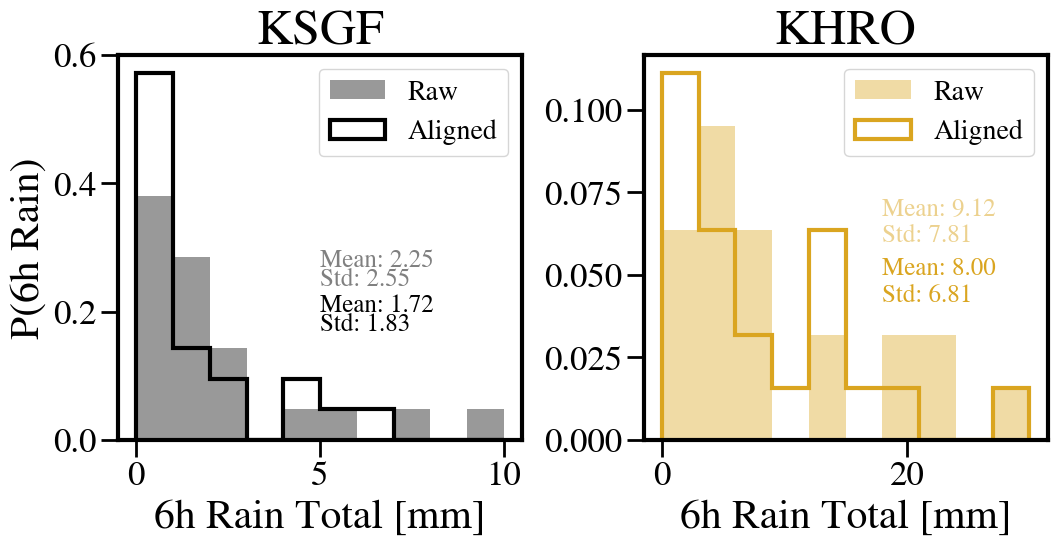

In [95]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
plt.subplots_adjust(wspace=0.3)

springfield = scipy.stats.gamma(*scipy.stats.gamma.fit(gefs_ksgf.APCP.data.compute()))
axes[0].hist(gefs_ksgf.APCP.data.compute(),color='black',range=(0,10),bins=10, alpha=0.4, label='Raw',density=True)
axes[0].hist(gefs_ksgf.Aligned_APCP.data.compute(),range=(0,10),bins=10,color='black', histtype='step',lw=3, label='Aligned',density=True)
xrange = np.linspace(0,30,200)
#axes[0].plot(xrange, springfield.pdf(xrange), color='black', lw=3,ls=':')

hro = scipy.stats.gamma(*scipy.stats.gamma.fit(gefs_khro.APCP.data.compute()))
axes[1].hist(gefs_khro.APCP.data.compute(),range=(0,30),bins=10,color='goldenrod', alpha=0.4,label='Raw',density=True)
axes[1].hist(gefs_khro.Aligned_APCP.data.compute(),range=(0,30),bins=10,color='goldenrod', histtype='step',lw=3, label='Aligned',density=True)
xrange = np.linspace(0,30,200)
#axes[1].plot(xrange, hro.pdf(xrange), color='goldenrod', lw=3,ls=':')

axes[0].annotate(f'Mean: {gefs_ksgf.APCP.mean(dim="member").data.compute()[0]:.2f}', xy=(5, 0.27), color='gray',fontsize=18)
axes[0].annotate(f'Std: {gefs_ksgf.APCP.std(dim="member").data.compute()[0]:.2f}', xy=(5, 0.24), color='gray',fontsize=18)
axes[0].annotate(f'Mean: {gefs_ksgf.Aligned_APCP.mean(dim="member").data.compute()[0]:.2f}', xy=(5, 0.20), color='black',fontsize=18)
axes[0].annotate(f'Std: {gefs_ksgf.Aligned_APCP.std(dim="member").data.compute()[0]:.2f}', xy=(5, 0.17), color='black',fontsize=18)

axes[1].annotate(f'Mean: {gefs_khro.APCP.mean(dim="member").data.compute()[0]:.2f}', xy=(18, 0.068), color='goldenrod',alpha=0.5,fontsize=18)
axes[1].annotate(f'Std: {gefs_khro.APCP.std(dim="member").data.compute()[0]:.2f}', xy=(18, 0.06), color='goldenrod',alpha=0.5,fontsize=18)
axes[1].annotate(f'Mean: {gefs_khro.Aligned_APCP.mean(dim="member").data.compute()[0]:.2f}', xy=(18, 0.05), color='goldenrod',fontsize=18)
axes[1].annotate(f'Std: {gefs_khro.Aligned_APCP.std(dim="member").data.compute()[0]:.2f}', xy=(18, 0.042), color='goldenrod',fontsize=18)

axes[0].set_ylabel('P(6h Rain)')
axes[0].set_xlabel('6h Rain Total [mm]')
axes[1].set_xlabel('6h Rain Total [mm]')
axes[0].legend()
axes[1].legend()
axes[0].set_title('KSGF')
axes[1].set_title('KHRO')

## Distortion Field

In [17]:
np.mean(ens_std[ens_std > 0])

0.5189944

In [57]:
min_lon = 240 
max_lon = 601
min_lat = 0
max_lat = 361
mem=4

m_k, n_k = basis_truncation(7)
y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
#get displacement basis functions, transforms grid x,y to fourier space
b_ik = basis_functions(x, y, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]])
d_o_f = len(m_k)

#free parameters
std = 0.52
S_a = 1.
S_mag = 0.8
#constraints for the minimization routine
def constrain_nonzero(x):
    c = np.sum(np.abs(x)) - 1e-3
    return c

constraints = {'type': 'ineq', 'fun': constrain_nonzero}


ens_mem = ens_members[mem,min_lat:max_lat,min_lon:max_lon]
#initialize coefficients
c_k = {"x": np.repeat(0.01, d_o_f), "y": np.repeat(0.01, d_o_f)}
ck_arr = np.ravel(np.array([c_k['x'], c_k['y']])) 
#minimize
#start = datetime.datetime.now()
minimize = scipy.optimize.minimize(fun=get_j,x0=ck_arr ,jac='3-point', 
                                   args=(b_ik, raw_mean[min_lat:max_lat,min_lon:max_lon],ens_mem, 
                                        std, S_a,S_mag,(x,y), m_k, n_k), method='SLSQP',constraints=constraints,
                                  options={'disp':True})
#coalesced grid
c_k_minimized = {"x": minimize.x[:np.shape(b_ik)[1]], "y": minimize.x[np.shape(b_ik)[1]:]}
c_xi = np.dot(b_ik, c_k_minimized['x'])
c_yi = np.dot(b_ik, c_k_minimized['y'])
n_x_i = x + c_xi
n_y_i = y + c_yi

aligned_ens = evaluate_at_new_grid(n_x_i, n_y_i, x, y, ens_mem)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.808522534220472
            Iterations: 11
            Function evaluations: 1245
            Gradient evaluations: 11


In [60]:
xy_displacements = np.meshgrid(c_yi, c_xi, indexing='ij')
displaced_grid = np.reshape(xy_displacements, (2, -1), order='C').T

In [61]:
c_k_minimized

{'x': array([-1.21267383e-04, -1.21267383e-04, -1.21267383e-04, -1.21267383e-04,
        -1.21267383e-04, -1.21267383e-04, -1.21267383e-04, -4.45197864e-05,
        -4.45197864e-05, -4.45197864e-05, -4.45191852e-05, -4.45197864e-05,
        -4.45197864e-05, -4.45197864e-05,  8.14196841e-06,  8.14196841e-06,
         8.14196846e-06,  8.14196846e-06,  8.14195330e-06,  8.14196846e-06,
         8.14196846e-06, -8.72473953e-06, -8.72473953e-06, -8.72473953e-06,
         1.25534719e-05,  1.25534719e-05,  1.25534719e-05,  1.25534719e-05]),
 'y': array([-1.21267383e-04, -1.21267383e-04, -1.21267383e-04, -1.21267383e-04,
        -1.21267383e-04, -1.21267383e-04, -1.21267383e-04, -4.45197867e-05,
        -4.45197867e-05, -4.45197867e-05, -4.45197867e-05, -4.45197867e-05,
        -4.45197867e-05, -4.45197865e-05,  8.14194555e-06,  8.14194554e-06,
         8.14194554e-06,  8.14194549e-06,  8.14194549e-06,  8.14194549e-06,
         8.14195327e-06, -8.72473934e-06, -8.72473952e-06, -8.72473952e-06,


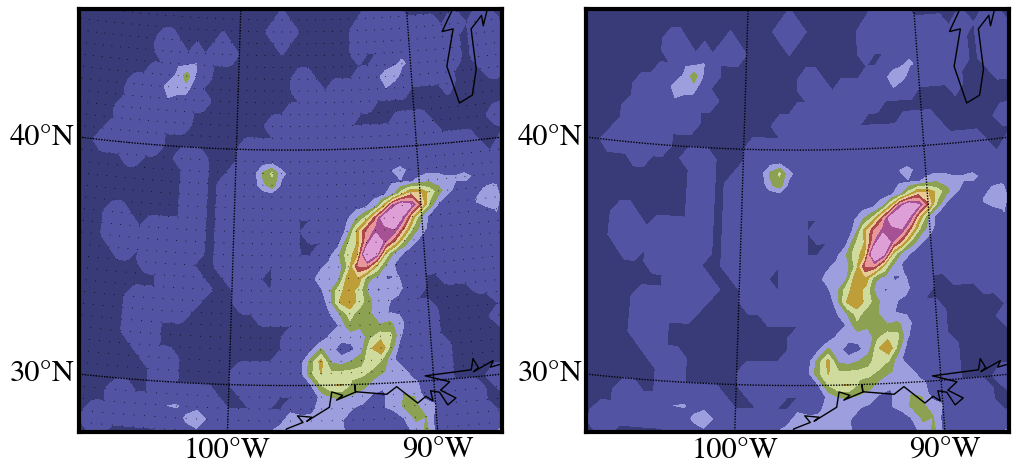

In [62]:
temp_range = np.arange(0,22,2)
fig, axes=plt.subplots(1,2, figsize=(12,8))
y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
lons, lats = np.meshgrid(x,y)
m = Basemap(projection='lcc',lon_0=-97,lat_0=37,width=2e6,height=2e6,resolution='c')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
cs = m.contourf(xx,yy,ens_mem ,levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[0])

for i in range(2):
    m.drawcoastlines(ax=axes[i])
    m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes[i])
    m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes[i])

m.quiver(xx, yy, displaced_grid[:,0], displaced_grid[:,1],angles='xy', scale_units='xy', scale=0.0000008, ax=axes[0])

m.contourf(xx,yy,aligned_ens,levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[1])